In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings(action="ignore")

In [5]:
X = pd.read_table('x_train.txt', sep=" ", header=None)
y = pd.read_table('y_train.txt', header=None).to_numpy(dtype=np.int8).squeeze()

In [6]:
df = X.copy()
df['target'] = y

# Compute full correlation matrix
corr_matrix = df.corr()

# --- 1. Pairwise correlations (variable-variable) ---
# Extract upper triangle of correlation matrix excluding the diagonal
pairwise_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
pairwise_corr_unstacked = pairwise_corr.unstack().dropna().sort_values(ascending=False)

# --- 2. Correlation with target ---
mi_scores = mutual_info_classif(X, y)
mi_series = pd.Series(mi_scores, index=X.columns)


# Display top results
print("Top variable-variable correlations:")
print(pairwise_corr_unstacked.head(25))

print("\nTop variable-target correlations:")
print(mi_series.sort_values(ascending=False).head(10))

Top variable-variable correlations:
7    4    0.955672
4    0    0.945690
8    3    0.928452
3    2    0.926740
7    0    0.905306
4    1    0.904025
6    3    0.903902
4    2    0.890128
9    1    0.890008
7    2    0.880251
6    2    0.877055
8    6    0.869994
1    0    0.864776
425  9    0.862438
9    8    0.850194
     3    0.849980
2    0    0.842314
7    5    0.841888
2    1    0.833284
6    5    0.823800
8    2    0.812423
5    2    0.795418
3    1    0.792708
9    2    0.792583
7    1    0.786311
dtype: float64

Top variable-target correlations:
2    0.095621
6    0.078624
3    0.070348
4    0.063540
5    0.062571
8    0.054368
9    0.049035
1    0.048552
7    0.047767
0    0.047250
dtype: float64


In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression

def calculate_vif(X):
    vif_df = pd.DataFrame()
    vif_df['feature'] = X.columns
    vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_df

def drop_high_vif_features(X: pd.DataFrame, y, vif_threshold=5.0):
    X = X.copy()
    
    # Step 1: Calculate correlation with target
    y_corr = pd.Series(mutual_info_classif(X, y))

    while True:
        vif_df = calculate_vif(X)
        print(vif_df.head(5))
        high_vif = vif_df[vif_df['VIF'] > vif_threshold]
        if high_vif.empty:
            break

        # Merge VIF and correlation info
        high_vif = high_vif.merge(y_corr.rename("target_corr"), left_on='feature', right_index=True)
        
        # Drop the feature with highest VIF and lowest correlation with y
        to_drop = high_vif.sort_values(['VIF', 'target_corr'], ascending=[False, True]).iloc[0]['feature']
        print(to_drop)
        print(f"Dropping: {to_drop} (VIF={high_vif.loc[high_vif['feature']==to_drop, 'VIF'].values[0]:.2f})")
        X.drop(columns=[to_drop], inplace=True, index=True)
        print(len(X.columns))
    return X

In [30]:
drop_high_vif_features(X[np.arange(30)],y)

   feature  VIF
0        0  inf
1        1  inf
2        2  inf
3        3  inf
4        4  inf
13.0
Dropping: 13.0 (VIF=inf)


KeyError: '[True] not found in axis'

In [3]:
def plot_histograms(df):
    n_features = df.shape[1]
    cols_per_segment=100
    segments = (n_features + cols_per_segment - 1) // cols_per_segment  # ceiling division

    for i in range(segments):
        start = i * cols_per_segment
        end = min(start + cols_per_segment, n_features)

        cols = df.columns[start:end]

        n_cols = 20  # number of subplots per row
        n_rows = (len(cols) + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols-1, n_rows-1))
        axes = axes.flatten()

        cmap = plt.cm.get_cmap("Set1", 10)

        for j, col in enumerate(cols):
            axes[j].hist(df[col].dropna(), bins=30, color=cmap(i))
            axes[j].set_xticks([])
            axes[j].set_yticks([])

        for k in range(len(cols), len(axes)):
            axes[k].axis('off')
        plt.suptitle(f'Features {start}-{end}', fontsize=20)
        plt.tight_layout()
        plt.show()

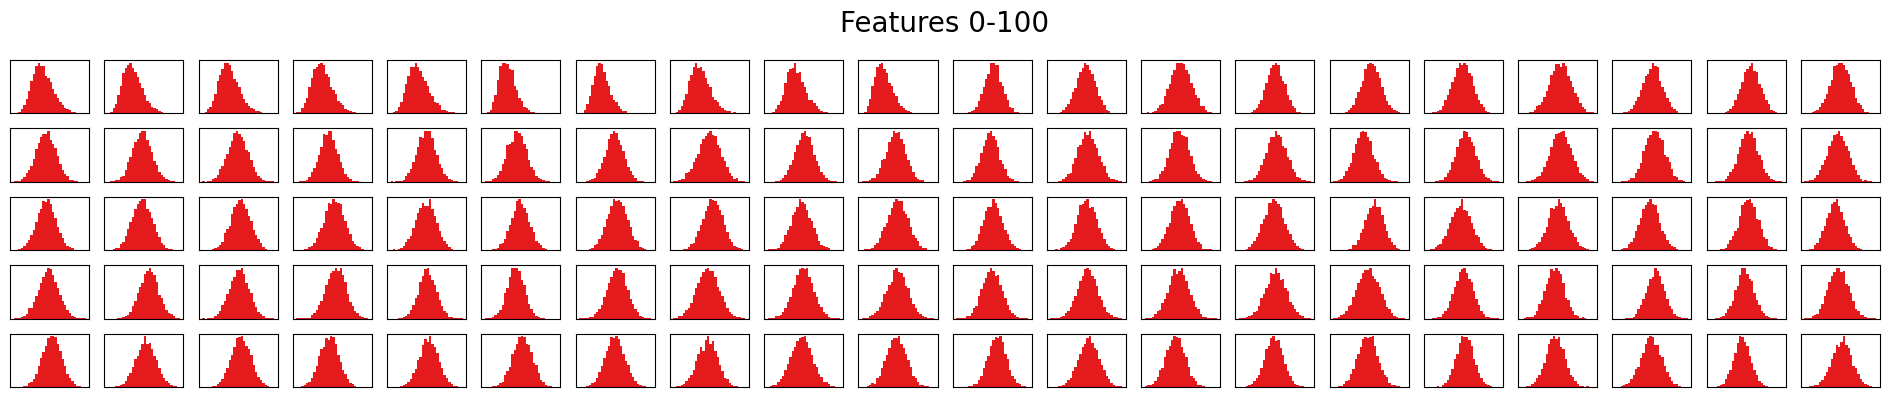

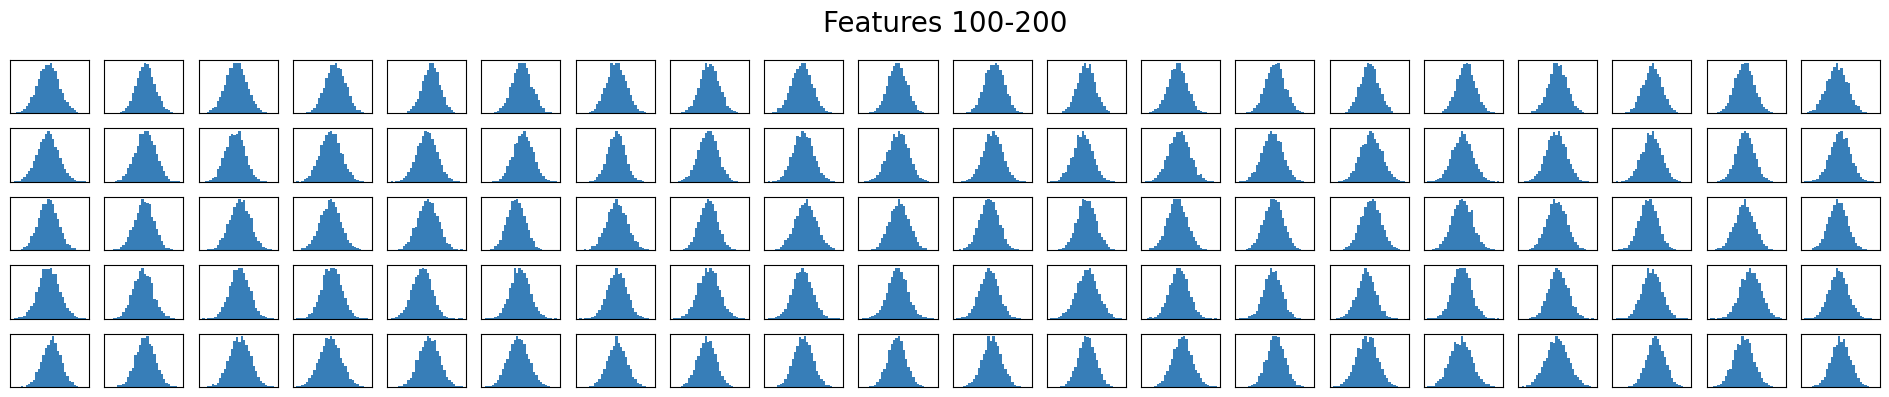

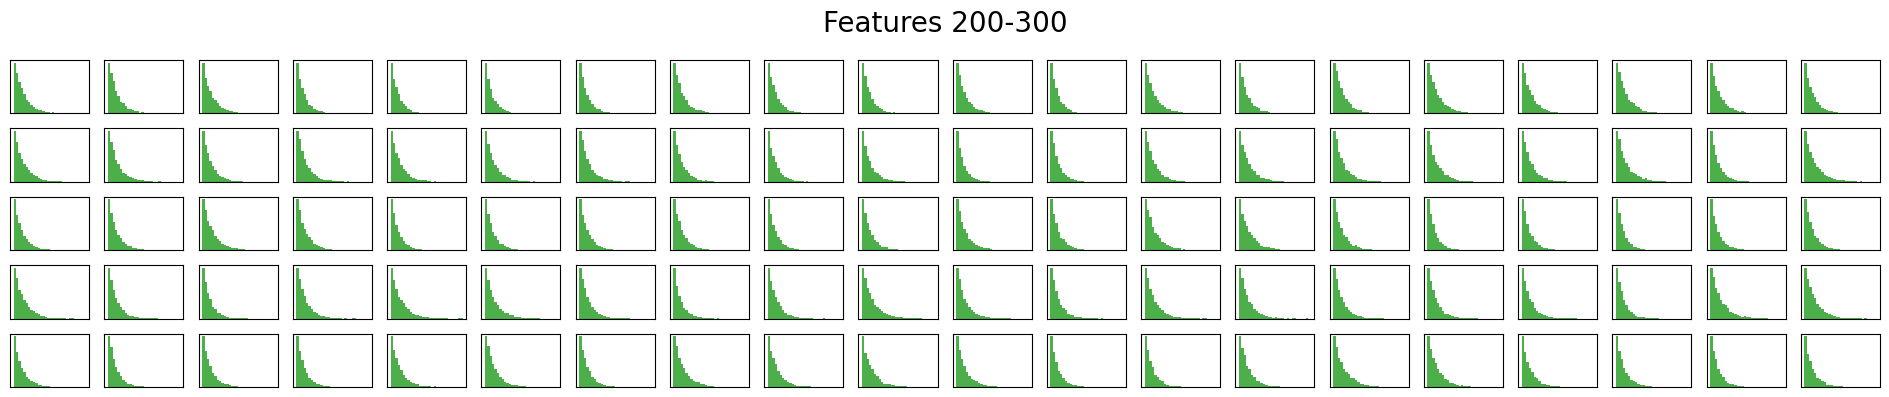

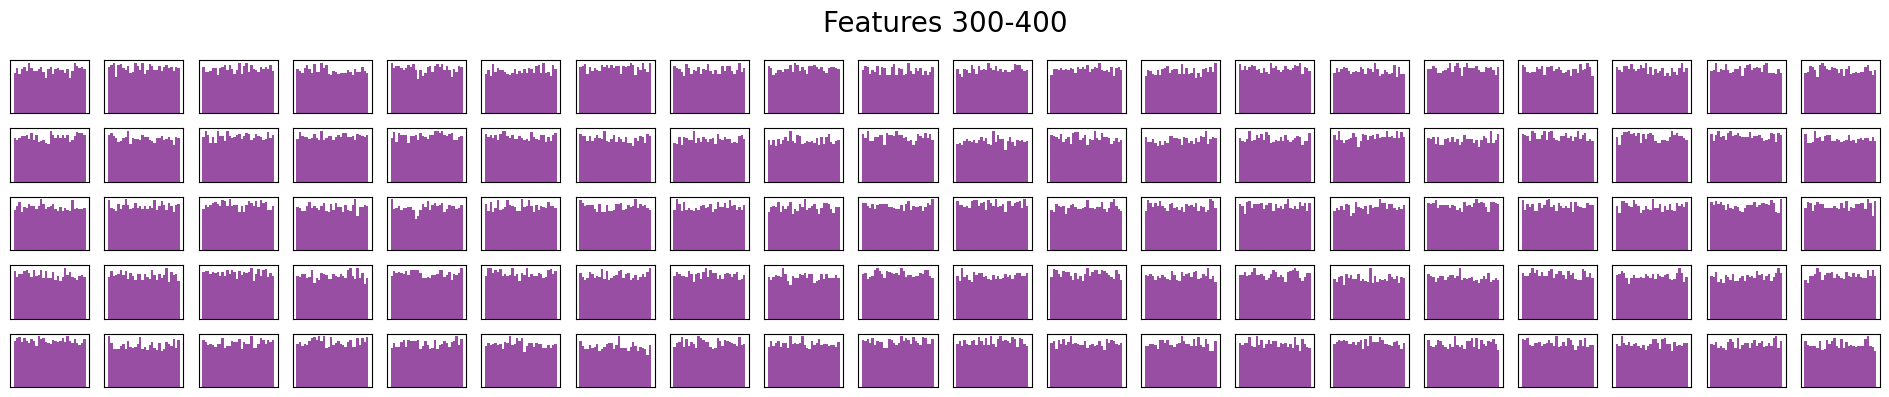

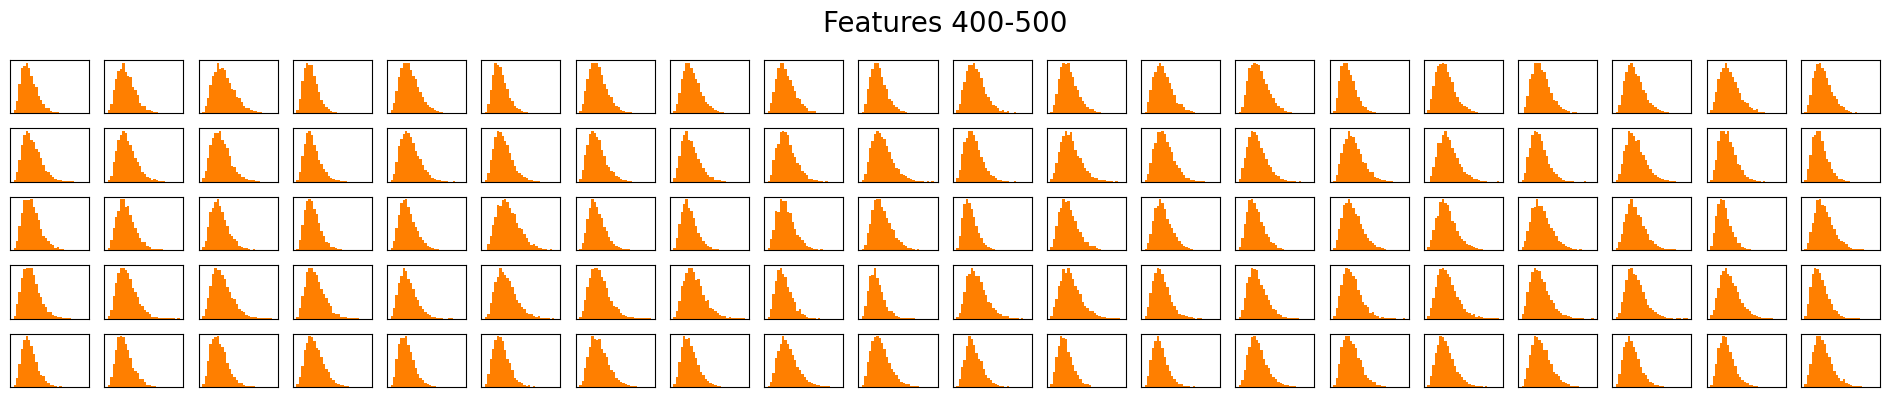

In [4]:
plot_histograms(X)

In [4]:
# 0-200    NORMAL (?)  (0-100 czasami troche skewed)
# 200-300  EXPONENTIAL
# 300-400  UNIFORM
# 400-500  NORMAL SKEWED

normal_cols = list(range(0, 200))
exponential_cols = list(range(200, 300))
uniform_cols = list(range(300, 400))
skewed_normal_cols = list(range(400, 500))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=200)

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import skew


# ==================== only standard scaler approach ====================
naive_scaler = StandardScaler()
X_train_naive_scaled = naive_scaler.fit_transform(X_train)
X_test_naive_scaled = naive_scaler.transform(X_test)

# ==================== unique transformation for each distribution ====================
column_transformer = ColumnTransformer([
    ('standard', StandardScaler(), normal_cols), # 0-200
    ('quantile', QuantileTransformer(output_distribution='normal', n_quantiles=200), exponential_cols), # 200-300
    ('minmax', MinMaxScaler(), uniform_cols), # 300 - 400
    ('power', Pipeline([
        ('power', PowerTransformer(method='yeo-johnson')),
        ('scaler', StandardScaler())
    ]), skewed_normal_cols) # 400-500
], remainder='passthrough')

X_train_adaptive_scaled = column_transformer.fit_transform(X_train)
X_test_adaptive_scaled = column_transformer.transform(X_test)


def evaluate_scaling(X_scaled, title="Scaling Evaluation"):
    min_vals = np.min(X_scaled, axis=0)
    max_vals = np.max(X_scaled, axis=0)
    means = np.mean(X_scaled, axis=0)
    stds = np.std(X_scaled, axis=0)
    
    print(f"===== {title} =====")
    print(f"Range: Min: {min_vals.min():.4f} to {max_vals.max():.4f}")
    print(f"Mean range: {means.min():.4f} to {means.max():.4f}")
    print(f"Std range: {stds.min():.4f} to {stds.max():.4f}")
    
    skewness = skew(X_scaled, axis=0)
    print(f"Skewness range: {skewness.min():.4f} to {skewness.max():.4f}")
    print(f"Absolute skewness > 0.5: {np.sum(np.abs(skewness) > 0.5)} features")
    print("\n")

evaluate_scaling(X_train_naive_scaled, "Standard Scaling (Naive)")
evaluate_scaling(X_train_adaptive_scaled, "Adaptive Scaling")

===== Standard Scaling (Naive) =====
Range: Min: -4.5935 to 10.2296
Mean range: -0.0000 to 0.0000
Std range: 1.0000 to 1.0000
Skewness range: -0.1175 to 2.2507
Absolute skewness > 0.5: 209 features


===== Adaptive Scaling =====
Range: Min: -5.1993 to 5.9328
Mean range: -0.0021 to 0.5080
Std range: 0.2851 to 1.0052
Skewness range: -0.1175 to 0.6767
Absolute skewness > 0.5: 9 features




In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import precision_score, recall_score

In [22]:
model = LogisticRegression("l1", solver='liblinear', C=0.01)

In [23]:
model.fit(X_train_adaptive_scaled, y_train)

LogisticRegression(C=0.01, penalty='l1', solver='liblinear')

In [24]:
selector = SelectFromModel(estimator=model, prefit=True)
selector.fit(X_train_adaptive_scaled)
X_selected = selector.transform(X_train_adaptive_scaled)
X_test_selected = selector.transform(X_test_adaptive_scaled)

In [32]:
selector.get_support(indices=True)

array([  2,   6, 298])

In [ ]:
X_selected.shape

(4800, 3)

In [ ]:
model = LogisticRegression("l2", solver='liblinear')
model.fit(X_selected, y_train)
y_pred = model.predict(X_test_selected)

In [26]:
sum(y_pred==y_test)/len(y_pred)

np.float64(0.74)

In [37]:
recall_score(y_test, y_pred)

0.6666666666666666